In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from laplace_hdc_helper import load_dataset
from laplace_hdc_encoder import hdc_encoder
from laplace_hdc_classifier import train_hdc_classifier, test_hdc_classifier
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from scipy.io import savemat, loadmat

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device:\t{device}")


Using device:	cuda:0


In [2]:
hyperdim = 5000 
bandwidth_parameter = 3 # bandwidth parameter
encoder_mode = 'shift_1d'
classifier_mode="float_sgd"
epochs=10

In [3]:
class_names = np.array(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])

# load the MNIST training data
train_data = datasets.FashionMNIST(
    '../../Data',
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

# Load the MNIST testing data
test_data = datasets.FashionMNIST(
    '../../Data',
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

num_classes = len(class_names)
print(num_classes)

10


lambda = 0.013442513532936573


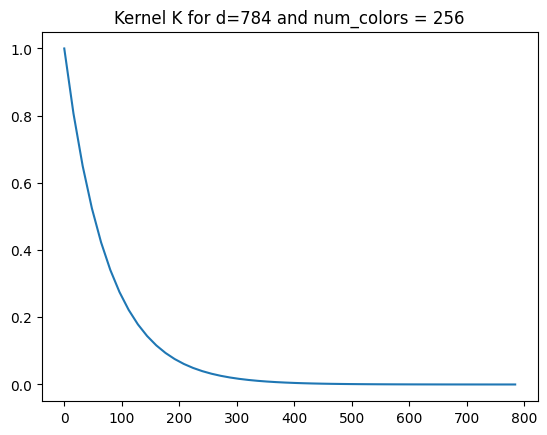

In [4]:
# Determining Lambda from random 1000 samples
batch_size = 1024
num_colors = 256

X,  _ = next(iter(DataLoader(train_data, batch_size=1000, shuffle=True)))
X = X.reshape(X.shape[0],-1)

D = torch.sum(torch.abs(X.unsqueeze(0)-X.unsqueeze(1)),dim=2)
a = torch.median(D.flatten())
lmd = bandwidth_parameter/a
print(f"lambda = {lmd}")

# Define the local kernel
x = np.linspace(0, 1, num=num_colors).reshape(-1, 1)
f = lambda X: 1 - lmd*X
kernel = f(np.abs(x - x.T))

# Visualize the global kernel
d = train_data[0][0].squeeze().numel()
S = lambda v: np.exp(-lmd*v)
v = np.linspace(0, d)
plt.plot(v, S(v))
plt.title(f"Kernel K for d={d} and num_colors = {num_colors}")
plt.show()

In [5]:
encoder = hdc_encoder(d, hyperdim, kernel, encoder_mode)
print(f"mode: {encoder_mode}\nHyperdimension: {encoder.hyperdim}")

mode: shift_1d
Hyperdimension: 5000


In [6]:
batch_size = 128
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

In [7]:
import torch
from torch.utils.data import TensorDataset
from typing import Optional   # ← add this

@torch.no_grad()
def flip_bits_bool(H: torch.BoolTensor,
                   perc: float,
                   *,
                   inplace: bool = True,
                   ) -> torch.BoolTensor:
    """
    Flip exactly round(perc·D) bits in each row of a boolean tensor H.

    Works on a flattened (M, D) view, then reshapes back to H’s shape.
    """
    if perc <= 0.0:
        return H if inplace else H.clone()

    flat = H.view(H.shape[0], -1)        # (M, D)
    M, D = flat.shape
    k = int(round(perc * D))
    if k == 0:
        return H if inplace else H.clone()

    out = flat if inplace else flat.clone()
    rows = torch.arange(M, device=H.device).repeat_interleave(k)

    cols = torch.cat([
        torch.multinomial(torch.ones(D, device=H.device),
                          k, replacement=False)
        for _ in range(M)
    ])

    out[rows, cols] = ~out[rows, cols]   # toggle bits (True ↔ False)
    return out.view_as(H)



def corrupt_dataset(dataset: TensorDataset, perc: float):
    """
    Return a new TensorDataset whose data tensor has been bit-flipped.
    Labels are untouched.
    """
    data, labels = dataset.tensors
    data_flipped = flip_bits_bool(data.clone(), perc)
    return TensorDataset(data_flipped, labels)


In [8]:
num_workers = 2
pin_memory=True
n_splits = 20
split_size = len(test_data) // n_splits
nHDC = 25_000
flip_percs = np.arange(0.0, 0.51, 0.05)
accuracies = np.zeros((len(flip_percs), n_splits))
for i, perc in enumerate(flip_percs):
    print(f'Percentage: {np.round(perc, 2)} Started --------------')
    # Train
    encoder = hdc_encoder(d, nHDC, kernel, encoder_mode)
    train_hdc = encoder.encode(train_loader)
    train_loader_hdc = DataLoader(
        train_hdc,
        batch_size=750,
        shuffle=True,
        num_workers=0,      # <-- no background workers
        pin_memory=False    # <-- nothing to pin; data is on GPU
    )
    model = train_hdc_classifier(train_loader_hdc, num_classes, mode=classifier_mode, epochs=10)
    print(f'Encoding Train Data and Training the Model for nHDC={nHDC} finished')
    for split_idx in tqdm(range(n_splits)):
        # Test
        start_idx = split_idx * split_size
        end_idx = start_idx + split_size
        split_subset = Subset(test_data, range(start_idx, end_idx))
        split_loader = DataLoader(
            split_subset,
            batch_size=128,
            shuffle=False,
            num_workers=num_workers,   # 2, as you set above
            pin_memory=pin_memory      # True
        )
        split_hdc = encoder.encode(split_loader)
        split_hdc = corrupt_dataset(split_hdc, perc=perc)
        split_loader_hdc = DataLoader(
            split_hdc,
            batch_size=128,
            shuffle=True,
            num_workers=0,
            pin_memory=False
        )
        accuracies[i, split_idx] = test_hdc_classifier(model, split_loader_hdc)
    print(f'Flip Percentage: {np.round(perc, 2)} Finished. Average Accuracy over 20 splits: {np.mean(accuracies[i])}')


Percentage: 0.0 Started --------------


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Encoding Train Data and Training the Model for nHDC=25000 finished


100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


Flip Percentage: 0.0 Finished. Average Accuracy over 20 splits: 0.8817
Percentage: 0.05 Started --------------


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Encoding Train Data and Training the Model for nHDC=25000 finished


100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Flip Percentage: 0.05 Finished. Average Accuracy over 20 splits: 0.8798999999999999
Percentage: 0.1 Started --------------


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Encoding Train Data and Training the Model for nHDC=25000 finished


100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


Flip Percentage: 0.1 Finished. Average Accuracy over 20 splits: 0.8803000000000001
Percentage: 0.15 Started --------------


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


Encoding Train Data and Training the Model for nHDC=25000 finished


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Flip Percentage: 0.15 Finished. Average Accuracy over 20 splits: 0.8707
Percentage: 0.2 Started --------------


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Encoding Train Data and Training the Model for nHDC=25000 finished


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Flip Percentage: 0.2 Finished. Average Accuracy over 20 splits: 0.869
Percentage: 0.25 Started --------------


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Encoding Train Data and Training the Model for nHDC=25000 finished


100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


Flip Percentage: 0.25 Finished. Average Accuracy over 20 splits: 0.8558999999999999
Percentage: 0.3 Started --------------


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Encoding Train Data and Training the Model for nHDC=25000 finished


100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


Flip Percentage: 0.3 Finished. Average Accuracy over 20 splits: 0.8351999999999998
Percentage: 0.35 Started --------------


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Encoding Train Data and Training the Model for nHDC=25000 finished


100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


Flip Percentage: 0.35 Finished. Average Accuracy over 20 splits: 0.7974
Percentage: 0.4 Started --------------


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Encoding Train Data and Training the Model for nHDC=25000 finished


100%|██████████| 20/20 [00:28<00:00,  1.45s/it]


Flip Percentage: 0.4 Finished. Average Accuracy over 20 splits: 0.7249000000000001
Percentage: 0.45 Started --------------


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Encoding Train Data and Training the Model for nHDC=25000 finished


100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


Flip Percentage: 0.45 Finished. Average Accuracy over 20 splits: 0.49260000000000004
Percentage: 0.5 Started --------------


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Encoding Train Data and Training the Model for nHDC=25000 finished


100%|██████████| 20/20 [00:30<00:00,  1.52s/it]

Flip Percentage: 0.5 Finished. Average Accuracy over 20 splits: 0.10540000000000002


In [9]:
np.mean(accuracies, axis=1)

array([0.8817, 0.8799, 0.8803, 0.8707, 0.869 , 0.8559, 0.8352, 0.7974,
       0.7249, 0.4926, 0.1054])

In [10]:
savemat('LaplaceHDC_FashionMNIST.mat', {'LaplaceHDC_FashionMNIST': accuracies*100})